In [ ]:
# Step 1: Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Step 2: Load the image
img_path = '/content/lanedetect2.png'  # Adjust path if necessary
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError("The image file 'lanedetect.png' was not found. Check the file path.")

# Convert BGR to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
# Step 3: Canny Edge Detection
def canny_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

edges = canny_edge_detection(img)

In [ ]:
# Step 4: Color Thresholding (Detecting White and Yellow Lanes)
def color_threshold(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # White color mask
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)

    # Yellow color mask
    lower_yellow = np.array([18, 94, 140])
    upper_yellow = np.array([48, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Combine masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return mask, masked_image

color_mask, masked_image = color_threshold(img)

In [ ]:
# Step 5: Hough Line Transform
def hough_lines(edges):
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=40, maxLineGap=5)
    line_img = np.zeros_like(img)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return line_img

line_img = hough_lines(edges)

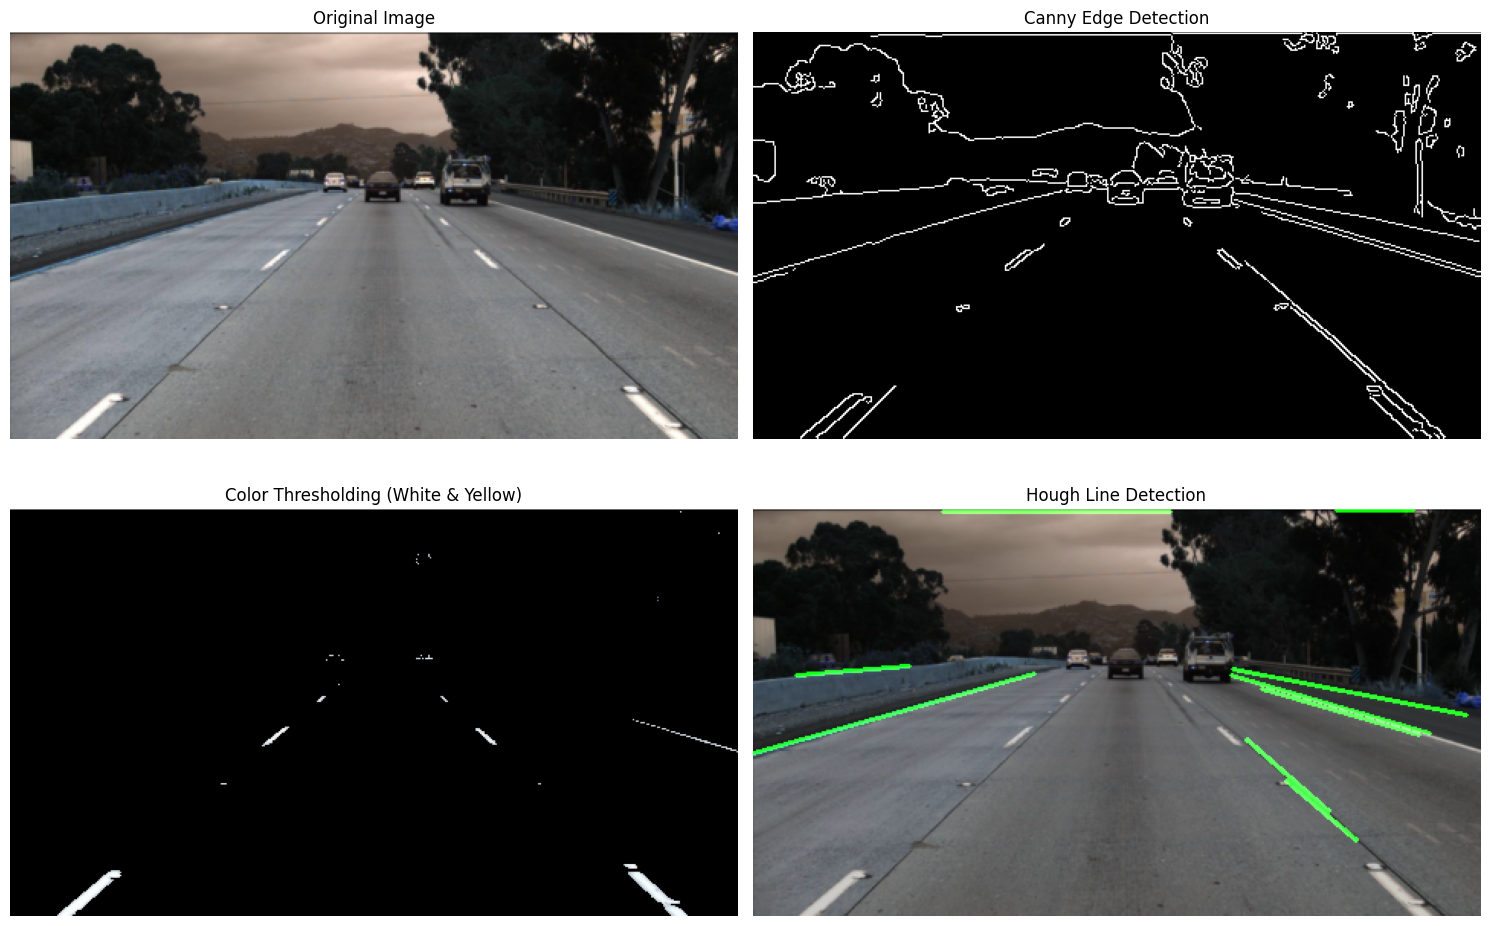

In [ ]:
# Step 6: Displaying the Results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Color Thresholding (White & Yellow)")
plt.imshow(masked_image)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Hough Line Detection")
result = cv2.addWeighted(img_rgb, 0.8, line_img, 1, 0)
plt.imshow(result)
plt.axis("off")

plt.tight_layout()
plt.show()

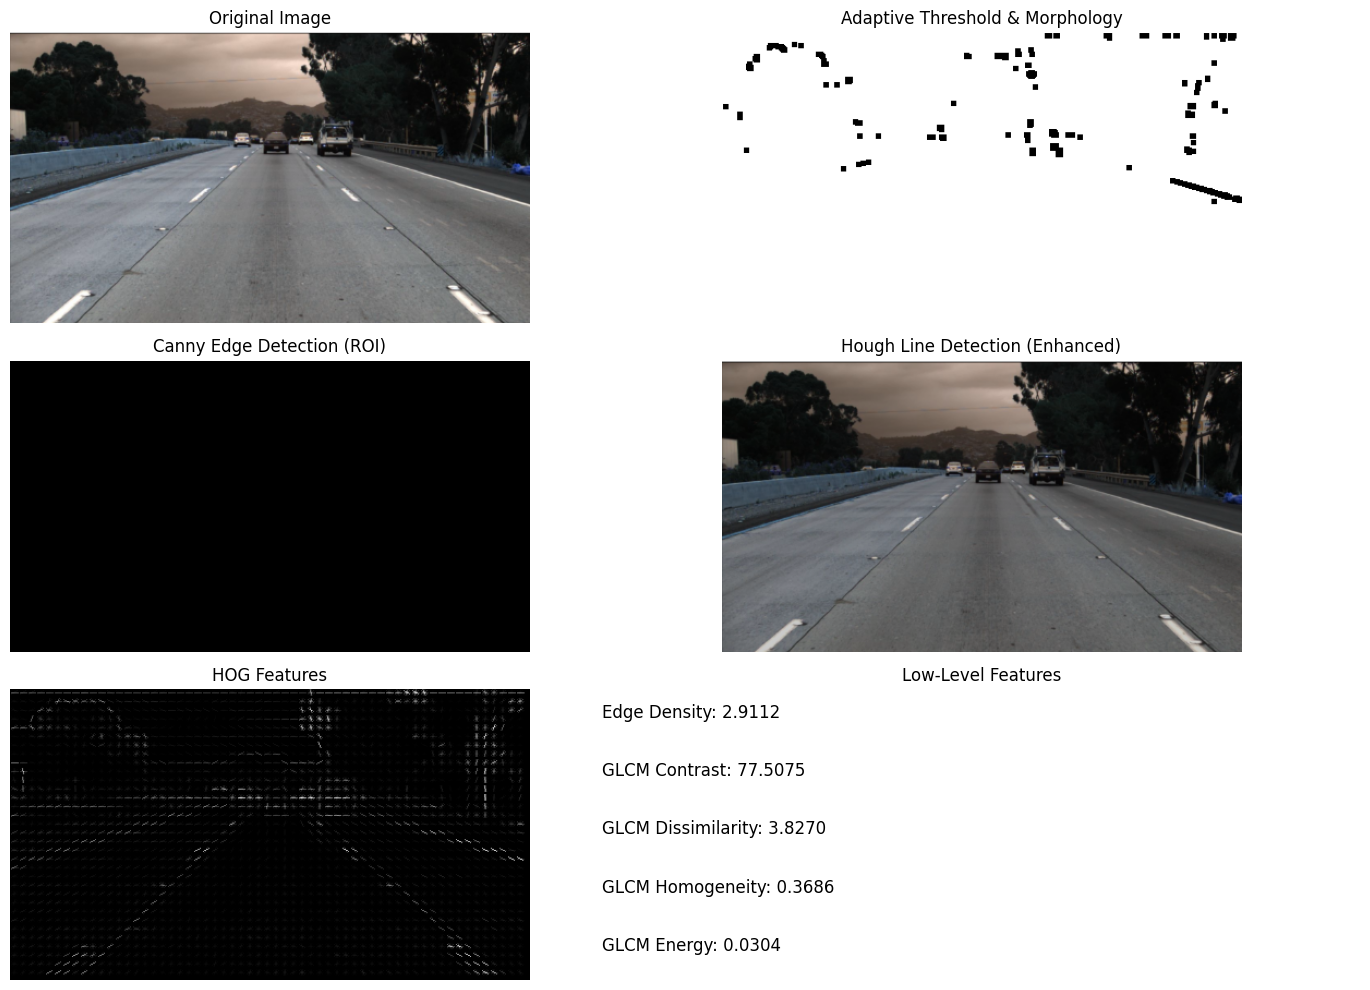

Low-Level Features Extracted:
Edge Density: 2.9112
GLCM Contrast: 77.5075
GLCM Dissimilarity: 3.8270
GLCM Homogeneity: 0.3686
GLCM Energy: 0.0304


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, graycomatrix, graycoprops

# Load the image
img_path = '/content/lanedetect2.png'
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError("The image file 'image.png' was not found. Check the file path.")

# Convert BGR to RGB and grayscale
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Color Space Analysis (HLS)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]

# Step 2: Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Step 3: Morphological Operations
kernel = np.ones((5, 5), np.uint8)
morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

# Step 4: Edge Detection using Canny
edges = cv2.Canny(morph, 50, 150)

# Step 5: Region of Interest (ROI)
height, width = edges.shape
mask = np.zeros_like(edges)

polygon = np.array([[
    (int(0.1 * width), height),
    (int(0.9 * width), height),
    (int(0.55 * width), int(0.6 * height)),
    (int(0.45 * width), int(0.6 * height))
]], np.int32)

cv2.fillPoly(mask, polygon, 255)
masked_edges = cv2.bitwise_and(edges, mask)

# Step 6: Hough Line Transformation (Probabilistic)
lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=40, minLineLength=50, maxLineGap=100)
line_img = np.zeros_like(img_rgb)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)

result = cv2.addWeighted(img_rgb, 0.8, line_img, 1, 0)

# --- Low Level Feature Extraction ---
# 1. Histogram of Oriented Gradients (HOG)
fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)

# 2. Edge Density
edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])

# 3. Color Histogram in HLS
h_hist = cv2.calcHist([hls], [0], None, [256], [0, 256])
l_hist = cv2.calcHist([hls], [1], None, [256], [0, 256])
s_hist = cv2.calcHist([hls], [2], None, [256], [0, 256])

# 4. Texture Features using GLCM
glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

# Display Results
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(3, 2, 2)
plt.title("Adaptive Threshold & Morphology")
plt.imshow(morph, cmap='gray')
plt.axis("off")

plt.subplot(3, 2, 3)
plt.title("Canny Edge Detection (ROI)")
plt.imshow(masked_edges, cmap='gray')
plt.axis("off")

plt.subplot(3, 2, 4)
plt.title("Hough Line Detection (Enhanced)")
plt.imshow(result)
plt.axis("off")

plt.subplot(3, 2, 5)
plt.title("HOG Features")
plt.imshow(hog_image, cmap='gray')
plt.axis("off")

plt.subplot(3, 2, 6)
plt.title("Low-Level Features")
plt.text(0, 0.9, f"Edge Density: {edge_density:.4f}", fontsize=12)
plt.text(0, 0.7, f"GLCM Contrast: {contrast:.4f}", fontsize=12)
plt.text(0, 0.5, f"GLCM Dissimilarity: {dissimilarity:.4f}", fontsize=12)
plt.text(0, 0.3, f"GLCM Homogeneity: {homogeneity:.4f}", fontsize=12)
plt.text(0, 0.1, f"GLCM Energy: {energy:.4f}", fontsize=12)
plt.axis("off")

plt.tight_layout()
plt.show()

print("Low-Level Features Extracted:")
print(f"Edge Density: {edge_density:.4f}")
print(f"GLCM Contrast: {contrast:.4f}")
print(f"GLCM Dissimilarity: {dissimilarity:.4f}")
print(f"GLCM Homogeneity: {homogeneity:.4f}")
print(f"GLCM Energy: {energy:.4f}")


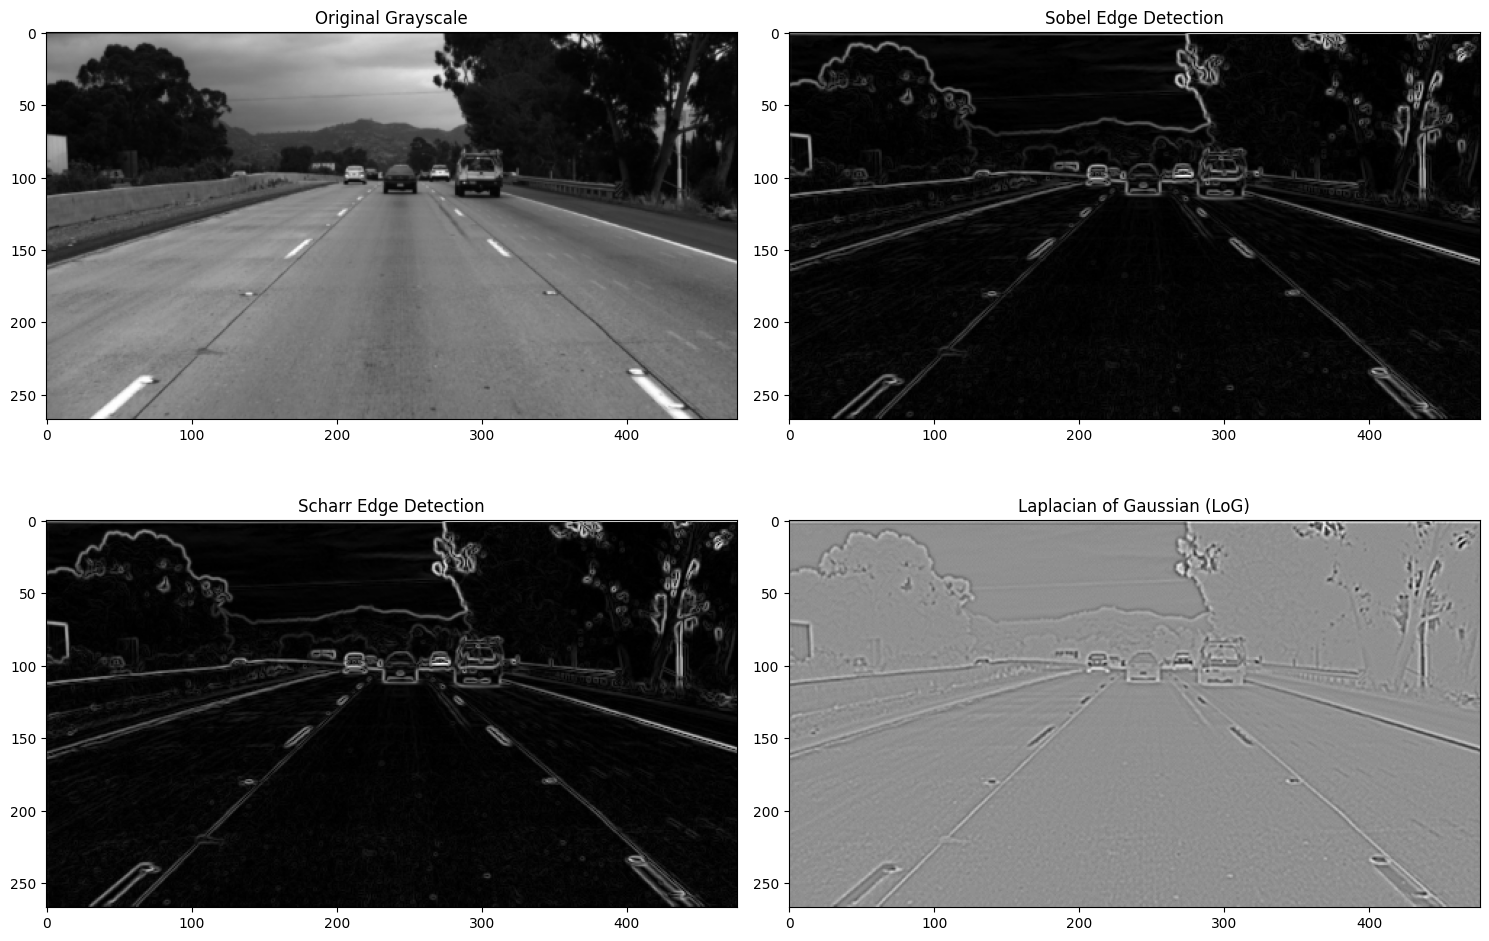

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/content/lanedetect2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Sobel Edge Detection
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # X direction
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Y direction
sobel = cv2.magnitude(sobel_x, sobel_y)

# Scharr Edge Detection (more sensitive than Sobel)
scharr_x = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharr_x, scharr_y)

# Laplacian of Gaussian (LoG)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
log = cv2.Laplacian(blurred, cv2.CV_64F)

# Plotting the results
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1), plt.imshow(gray, cmap='gray'), plt.title('Original Grayscale')
plt.subplot(2, 2, 2), plt.imshow(sobel, cmap='gray'), plt.title('Sobel Edge Detection')
plt.subplot(2, 2, 3), plt.imshow(scharr, cmap='gray'), plt.title('Scharr Edge Detection')
plt.subplot(2, 2, 4), plt.imshow(log, cmap='gray'), plt.title('Laplacian of Gaussian (LoG)')
plt.tight_layout()
plt.show()


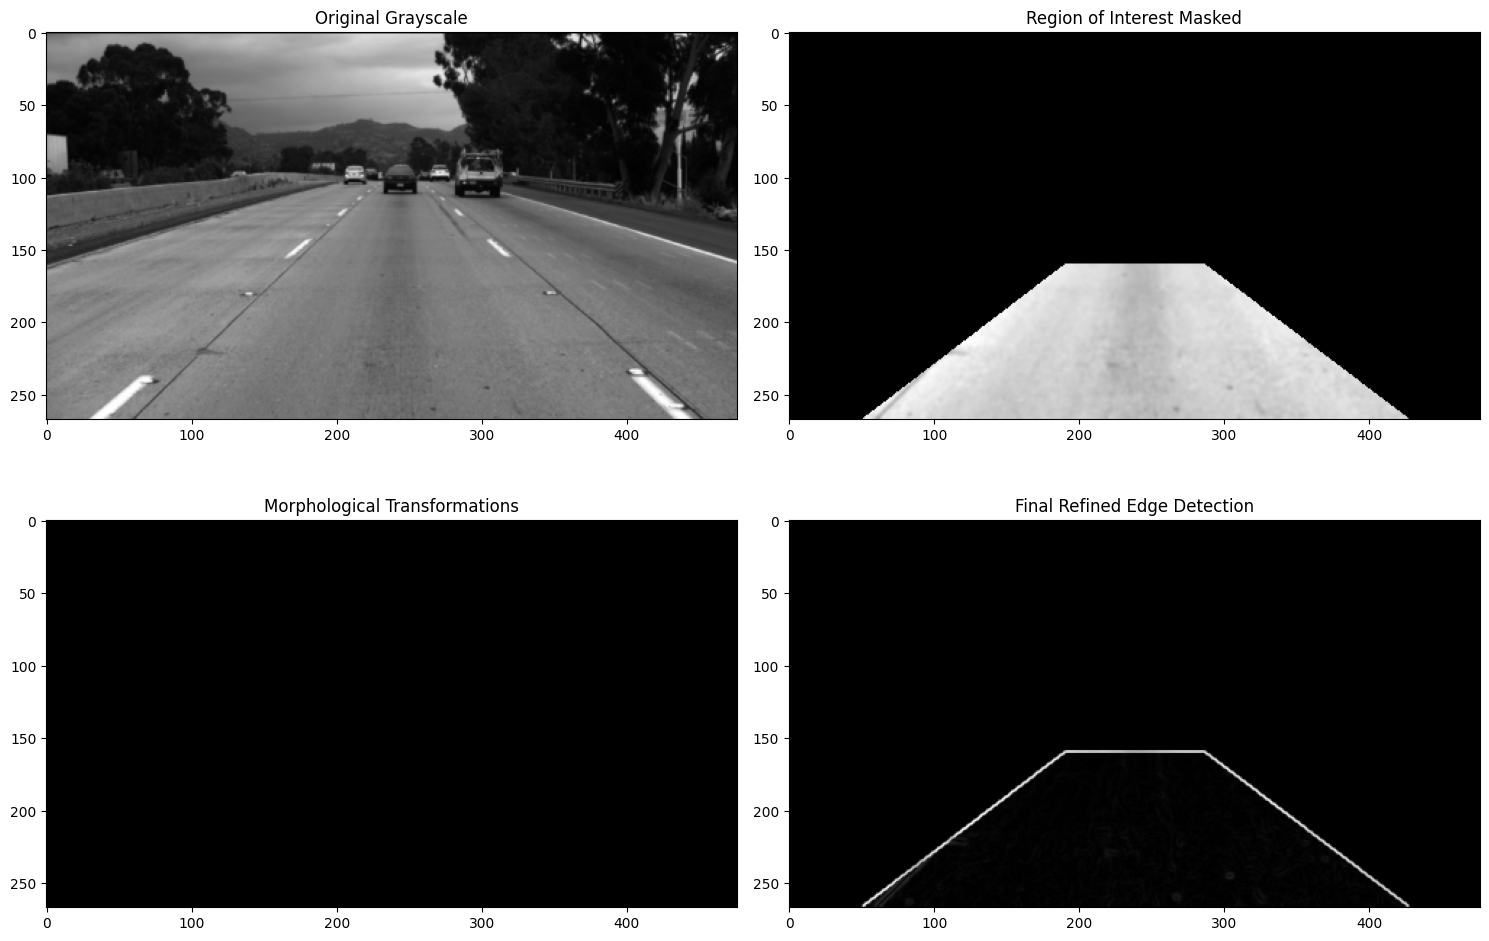

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/content/lanedetect2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Define a Region of Interest (ROI) - Trapezoidal mask
height, width = gray.shape
roi_mask = np.zeros_like(gray)

# Define vertices for the mask (adjust based on your image)
vertices = np.array([[(50, height), (width - 50, height), (int(0.6 * width), int(0.6 * height)), (int(0.4 * width), int(0.6 * height))]], dtype=np.int32)
cv2.fillPoly(roi_mask, vertices, 255)
masked_image = cv2.bitwise_and(blurred, roi_mask)

# Advanced Edge Detection: Sobel + Adaptive Threshold
sobel_x = cv2.Sobel(masked_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(masked_image, cv2.CV_64F, 0, 1, ksize=3)
# Calculate the magnitude of the gradients
sobel_combined = cv2.magnitude(sobel_x, sobel_y)
# Normalize and convert to uint8 to match morph's type
sobel_combined = np.uint8(cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX))


# Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(masked_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Morphological Transformations to reduce noise
kernel = np.ones((5, 5), np.uint8)
morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
morph = np.uint8(morph)  # Ensure morph is of type uint8

# Final Edge Detection (with type-matched inputs)
final_edges = cv2.bitwise_and(sobel_combined, morph)

# Plotting the results
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1), plt.imshow(gray, cmap='gray'), plt.title('Original Grayscale')
plt.subplot(2, 2, 2), plt.imshow(masked_image, cmap='gray'), plt.title('Region of Interest Masked')
plt.subplot(2, 2, 3), plt.imshow(morph, cmap='gray'), plt.title('Morphological Transformations')
plt.subplot(2, 2, 4), plt.imshow(final_edges, cmap='gray'), plt.title('Final Refined Edge Detection')
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import skimage.feature as skf
from scipy.stats import skew

# Edge-detected image from previous step (masked_edges)
edges = masked_edges

# Step 1: Edge Density
edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])

# Step 2: Edge Orientation Histogram using Sobel
sobel_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_angle = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)  # In degrees

# Orientation Histogram
orientation_hist, _ = np.histogram(gradient_angle, bins=8, range=(-180, 180))

# Step 3: Gradient Magnitude Statistics
mean_grad = np.mean(gradient_magnitude)
variance_grad = np.var(gradient_magnitude)
skewness_grad = skew(gradient_magnitude.flatten())

from skimage.feature import graycomatrix, graycoprops

# Convert the image to grayscale if not already done
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute the GLCM
glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)

# Extract texture features
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

# Displaying Results
print(f"Edge Density: {edge_density:.4f}")
print(f"Edge Orientation Histogram: {orientation_hist}")
print(f"Gradient Magnitude - Mean: {mean_grad:.4f}, Variance: {variance_grad:.4f}, Skewness: {skewness_grad:.4f}")
print(f"Texture Features - Contrast: {contrast:.4f}, Correlation: {correlation:.4f}, Energy: {energy:.4f}, Homogeneity: {homogeneity:.4f}")

Edge Density: 0.1811
Edge Orientation Histogram: [  2093   1991   2593   2052 109313   2936   3332   3049]
Gradient Magnitude - Mean: 225.2200, Variance: 1093978.8401, Skewness: 8.1986
Texture Features - Contrast: 77.5075, Correlation: 0.9861, Energy: 0.0304, Homogeneity: 0.3686


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the road image
image = cv2.imread("/content/lanedetect1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blurring to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny Edge Detection
edges = cv2.Canny(blurred, 50, 150)

# Create a mask to focus on the region of interest (ROI)
mask = np.zeros_like(edges)
height, width = edges.shape
polygon = np.array([[
    (int(0.1 * width), height),
    (int(0.45 * width), int(0.6 * height)),
    (int(0.55 * width), int(0.6 * height)),
    (int(0.9 * width), height)
]], np.int32)

cv2.fillPoly(mask, polygon, 255)
roi_edges = cv2.bitwise_and(edges, mask)

# Hough Line Detection for lane detection
lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)

# Create a copy of the original image to draw lines
line_image = np.copy(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Road Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Detected Lane Lines")
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()